# Class Model Visualisation

The idea of class model visualisation arises from the need to somehow open the black box that Neural Networks are when trying to interpret them. This technique  was first developed [[1]](https://arxiv.org/pdf/1312.6034.pdf) to use in image classifying ConvNets. Basically, the idea is to let the network numerically *generate* an image which is representative of the class, that is, the optimal input that the network could receive to classify it inside that class.

Some of the generated images looked like the following:
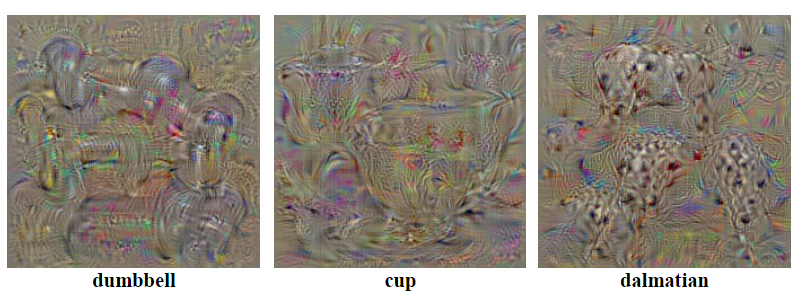

Formally, let $S_c(I)$ be the score of the class $c$, computed by the classification layer of the ConvNet for an image $I$. We would like to find an $L_2$-regularized image, such that the score $S_c$ is high:


$$arg \ max\ S_c(I) - \lambda \parallel I\parallel_2^2$$

$\lambda$ is the regularisation parameter. A locally-optimal $I$ can be found by back-propagation in the same way the layer weights are optimized during training. This time, however, the weights are fixed and the optimization is performed with respect to the input image. 

It's also important to note that the maximization should be done to the unnormalised class scores $S_c$, since the normalized ones, which have undergone softmax transformation $\big(\frac{exp\ S_c}{\sum_c exp \ S_c}\big)$, can be maximized just by minimizing the scores of other classes.  


## Application in DNA sequence data:

Later on, this technique was adapted [[2]](https://arxiv.org/pdf/1608.03644.pdf) to use with DNA sequence data by the [DeepMotif](https://qdata.github.io/deep4biomed-web//) Team. They built neural networks predicting whether certain sequences contain a Transcription Factor Binding Site (TFBS) or not. In order to actually visualize what was learnt by the network, they used Class Model Visualization, which they call Class Optimization:

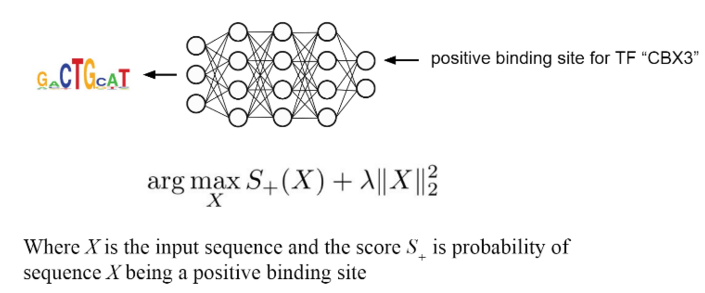

Basically, they obtain a "motif" representing the optimal input for a positively identified TFBS. The authors claim that the motifs generated with their approach with CNNs (they used both CNNs and RNNs) were found to appear as known motifs in the JASPAR database. 

In the setup of the approach, the method is the same as the one used to generate images, but in this case the optimization is done on the DNA sequence. Initial values of 0.25 are given to each nucleotide in the input and then they are optimized by back-propagation. 

## Application in Protein Sequence data:

In the same way that this method could be used to generate motifs in DNA sequence data, it should be applicable to protein sequence data too. In my approach, I try to predict the subcellular location of proteins based solely on their sequence. Taken this into account, I could use this technique to predict, using the different models I have trained, which would be the optimal input my network could receive for each of the different classes. The result could then be translated to a PSSM and represented as a motif. I will try to do so in the following code snippets.  

The first step is to load the necessary modules and restore the graph of an already trained network. 

In [4]:
from __future__ import division
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from neural_networks import *

In [5]:
curr_dir = os.getcwd()
model_dir ="logs2/2017-10-31 13:39:35-0.02-500-drop0.8-100x11)(seq+props)seqlen=750forwardLSTM"

### Restoring Graph Data
Define the structure of the graph in order to restore it. Although this is not needed in order to restore the metagraph, we will need to access to the last layer `y`, and therefore we can define the structure to have it in the variables space.

A change will be done in the structure, though, what before was the regular input, `x`, will now be `optimal_x`, the variable that we are actually going to optimize now. 

The graph I am restoring had the following structure: 

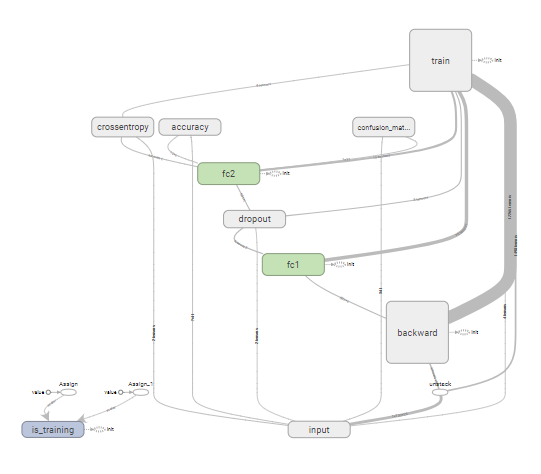

The input `x` gets reversed via the `tf.reverse()` operation and is then fed to a `LSTM` layer, called `backwards` since it is unidirectional on the backward direction. The input sequence is unstacked on a aa per aa basis (this are the timepoints for the LSTM layer) before being fed to the `LSTM`layer. The output of the `LSTM` layer is then fed to a fully connected layer, `fc1`, which has 250 nodes. The output of this layer is then fed to `fc2`, which outputs 11 values, the unscaled logits. These go there through a softmax step and are converted to probabilities for each of the classes. 

In [6]:
seq_len = 750
aa_vec_len = 20
n_labels = 11
n_units_lstm = 100
n_units_fc = 250
n_timesteps = seq_len
out_lstm_size = 100
learn_step = 0.1

def trainable_input(shape, name="trainable_x"):
    initial = tf.constant(1/aa_vec_len, shape=shape)
    return tf.Variable(initial, name)

with tf.name_scope("input"):
    optimal_x = trainable_input([1, seq_len, aa_vec_len])
    tf.add_to_collection("class_optimizing", optimal_x)
    x_back = tf.reverse(optimal_x, [1])
    y_ = tf.placeholder(tf.float32, [None, n_labels], name="labels")
    keep_prob = tf.placeholder(tf.float32, name="dropout_rate")
   
pre_lstm = tf.unstack(x_back, n_timesteps, 1) # Unstack the tensor, 1 aa is fed to each lstm cell each timepoint
post_lstm = LSTM(pre_lstm, n_units_lstm, out_lstm_size, name="backward")
fc1 = tf.nn.dropout(fc_layer(post_lstm, out_lstm_size, n_units_fc, relu=True, name="fc1"), keep_prob)
y = fc_layer(fc1, n_units_fc, n_labels, relu=True, name="fc2")

### Redefining loss (score) function and training step


The objective of the network is not anymore to train the weights to minimize the Crossentropy when classifying the sequences. 
The objective now is to train and optimize the variables of the input which will maximize the score for each of the labels.   

`AdamOptimizer` will now try to maximize the value of `class_score` instead of minimizing the value of the `cross_entropy`. Since by default `AdamOptimizer` has a minimizing function and not a maximizing one, I redefined the score as the negative value of the unscaled logit for each class. That way, while minimizing the negative value we are actually maximizing the score.

Another important step is to make sure that `AdamOptimizer` doesn't train and change the weights as it does usually. By default, al variables created in a graph are introduced in the collection `tf.trainable_variables()` and `AdamOptimizer` tries to optimize them. For that reason, I created a new collection `class_optimizing` to which I assigned `optimal_x`. When calling `AdamOptimizer` at the definition of the `train_step`, I specify that only variables in the collection `class_optimizing` should be trained. 


In [7]:
# Define score function:
with tf.name_scope("class_score"):
    # y is the last layer, contains unscaled logits
    # y_ is a one-hot vector containing the true label
    pos = tf.argmax(y_, 1)
    score = -tf.gather(y[0], pos)
    tf.summary.scalar("class_score", score)


with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learn_step).minimize(score, var_list=tf.get_collection("class_optimizing"))

In [ ]:
# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()  # Start tensorflow session
sess.run(init_op)

# Restore variables from disk (Specify network location)
saver = tf.train.import_meta_graph(model_dir + "/model.ckpt.meta")
saver.restore(sess, tf.train.latest_checkpoint(model_dir + '/./'))

INFO:tensorflow:Restoring parameters from logs2/2017-10-31 13:39:35-0.02-500-drop0.8-100x11)(seq+props)seqlen=750forwardLSTM/./model.ckpt


### Keeping input values inside realistic range

Since the input we are trying to predict now should not just be a series of vectors with random values, but something that could actually be a protein sequence, it's necessary to force the algorithm to keep the values inside realistic limits that could eventually be interpretable as a PSSM. Actual inputs are series of 1-hot vectors representing each one of the aminoacids on each position of the sequence. Example with nucleotides for simplicity:  
  
  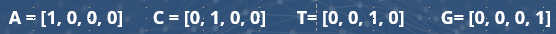

This means that the vectors representing each of the positions of the sequence should:
- Contain only positive values
- All values should be < 0 and > 1
- The sum of all values in each position should be 1

For that reason, in each training step, negative values will be converted to 0 and then the function `standardize_tensor` will divide all numbers by the total sum in order to make the sum of all of them 1. While it's not possible to direct the optimization towards any direction and put constraints to it, making this at every step makes sure that the values don't fall into unrealistic ranges. 

The initial values when starting are 1/20 to give equal starting probability to each aminoacid in each position. 

In [ ]:
label_tensor = [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

def standardize_tensor(tensor):
    """
    Takes a tensor and performs a row-wise standardization, returning a tensor of the same shape.
    """
    sums = tf.reduce_sum(tensor, 2)
    sums = tf.expand_dims(sums, 2)
    final_tensor = tensor / sums
    return final_tensor

n_epochs = 1000

for i in range(n_epochs):
    train_step.run(feed_dict={y_:label_tensor, keep_prob: 1})
    # make negative values = 0
    no_neg_x = tf.where(tf.less(optimal_x, tf.zeros_like(optimal_x)), tf.zeros_like(optimal_x), optimal_x)
    # standardize all values to sum 1 in a row per row manner
    optimal_x = standardize_tensor(no_neg_x)
    
    t, opt_x = sess.run([score, optimal_x], feed_dict={y_: label_tensor, keep_prob: 1})
    
    opt_x = opt_x[0]


Finally, after optimizing the input for each label, a dataframe containing it can be saved and used to produce a logo with `seq2logo`. 

In [ ]:
pssm_df = pd.DataFrame(opt_x)
pssm_df.columns = list("ARNDCEQGHILKMFPSTWYV")

with open(os.path.join(curr_dir, "sequence_pssm.txt"), 'w') as outfile:
    pssm_df.to_string(outfile)

preprocess.run_seq2logo("sequence_pssm.txt", "seqlogo")